In [ ]:
!pip install "tensorflow==1.15.0"
!pip install tensorflow-hub

     |████████████████████████████████| 412.3MB 42kB/s 
     |████████████████████████████████| 512kB 41.4MB/s 
     |████████████████████████████████| 3.8MB 43.3MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=ca7b0cc00a302512efe07d6abe82e91766878276ebd9b28066d8def54b643f49
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully 

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
import pandas as pd
import numpy as np

elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

def ELMoEmbedding(input_text):
    return elmo(tf.reshape(tf.cast(input_text, tf.string), [-1]), signature="default", as_dict=True)["elmo"]

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
dataset = pd.read_csv('/content/drive/My Drive/data/dataset.csv', delimiter = ',')
#dataset = pd.read_csv('/content/drive/My Drive/data/data_small_sec.csv', delimiter = ',')
#dataset = dataset[:1000]
data = pd.DataFrame([' '.join(t.split()[0:150]) for t in dataset['text']]) #for saving memory

In [ ]:
#150
from tensorflow.keras.layers import Input, Lambda, Bidirectional, Dense, Dropout, LSTM
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, KFold
import numpy as np

# K-fold Cross Validation model evaluation
fold_no = 1

#X_train, X_test, y_train, y_test = train_test_split(data, dataset[['label']], test_size=0.3, random_state=4)
def build_model():
  input_layer  = Input(shape=(1,), dtype="string", name="Input_layer")
  embedding_layer = Lambda(ELMoEmbedding, output_shape=(1024, ), name="Elmo_Embedding")(input_layer)

  x = Bidirectional(LSTM(1024, return_sequences= False, recurrent_dropout=0.2, dropout=0.2), name="BiLSTM")(embedding_layer)
  x = Dense(2048, activation="relu")(x)
  x = Dropout(0.1)(x)
  x = Dense(100, activation="relu")(x)
  x = Dropout(0.1)(x)
  x = Dense(1, activation="sigmoid")(x)
  model = Model(inputs=input_layer,outputs=x)
  model.summary()
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model
elmo_LSTM_model = build_model()
kfold = KFold(n_splits=5, random_state=4, shuffle=True)
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
target = dataset[['label']]
with tf.Session() as session:
  session.run(tf.global_variables_initializer()) 
  session.run(tf.tables_initializer())
  fold_no = 1
  for train, test in kfold.split(data, target):
    history = elmo_LSTM_model.fit(data.loc[train], target.loc[train],epochs=1, batch_size=128,verbose = 1)
    scores = elmo_LSTM_model.evaluate(data.loc[test], target.loc[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
Elmo_Embedding (Lambda)      (None, None, 1024)        0         
_________________________________________________________________
BiLSTM (Bidirectional)       (None, 2048)              16785408  
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               204900    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0   

In [ ]:
#150
from tensorflow.keras.layers import Input, Lambda, Bidirectional, Dense, Dropout, LSTM
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, dataset[['label']], test_size=0.3, random_state=4)
def build_model():
  input_layer  = Input(shape=(1,), dtype="string", name="Input_layer")
  embedding_layer = Lambda(ELMoEmbedding, output_shape=(1024, ), name="Elmo_Embedding")(input_layer)

  x = Bidirectional(LSTM(1024, return_sequences= False, recurrent_dropout=0.2, dropout=0.2), name="BiLSTM")(embedding_layer)
  x = Dense(2048, activation="relu")(x)
  x = Dropout(0.2)(x)
  x = Dense(100, activation="relu")(x)
  x = Dropout(0.2)(x)
  x = Dense(1, activation="sigmoid")(x)
  model = Model(inputs=input_layer,outputs=x)
  #model.summary()
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model
elmo_LSTM_model = build_model()

with tf.Session() as session:
  session.run(tf.global_variables_initializer()) 
  session.run(tf.tables_initializer())
  history = elmo_LSTM_model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=4, batch_size=128)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Train on 35863 samples, validate on 15370 samples
Epoch 1/4
35863/35863 [==============================] - 1215s 34ms/sample - loss: 0.0762 - acc: 0.9723 - val_loss: 0.0447 - val_acc: 0.9856
Epoch 2/4
35863/35863 [==============================] - 1207s 34ms/sample - loss: 0.0376 - acc: 0.9871 - val_loss: 0.0387 - val_acc: 0.9866
Epoch 3/4
35863/35863 [==============================] - 1201s 33ms/sample - loss: 0.0243 - acc: 0.9912 - val_loss: 0.0321 - val_acc: 0.9885
Epoch 4/4
35863/35863 [==============================] - 1200s 33ms/sample - loss: 0.0142 - acc: 0.9948 - val_loss: 0.0438 - val_acc: 0.9866


In [ ]:
import matplotlib.pyplot as plt

### use 140 words

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Bidirectional, Dense, Dropout, LSTM
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, dataset[['label']], test_size=0.3, random_state=4)
def build_model():
  input_layer  = Input(shape=(1,), dtype="string", name="Input_layer")
  embedding_layer = Lambda(ELMoEmbedding, output_shape=(1024, ), name="Elmo_Embedding")(input_layer)

  x = Bidirectional(LSTM(1024, return_sequences= False, recurrent_dropout=0.2, dropout=0.2), name="BiLSTM")(embedding_layer)
  x = Dense(2048, activation="relu")(x)
  x = Dropout(0.1)(x)
  x = Dense(100, activation="relu")(x)
  x = Dropout(0.1)(x)
  x = Dense(1, activation="sigmoid")(x)
  model = Model(inputs=input_layer,outputs=x)
  model.summary()
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model
elmo_LSTM_model = build_model()

with tf.Session() as session:
  session.run(tf.global_variables_initializer()) 
  session.run(tf.tables_initializer())
  history = elmo_LSTM_model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=4, batch_size=128)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
Elmo_Embedding (Lambda)      (None, None, 1024)        0         
_________________________________________________________________
BiLSTM (Bidirectional)       (None, 2048)              16785408  
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               204900    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0     

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 35863 samples, validate on 15370 samples
Epoch 1/4
35863/35863 [==============================] - 1118s 31ms/sample - loss: 0.2320 - acc: 0.9058 - val_loss: 0.1260 - val_acc: 0.9517
Epoch 2/4
35863/35863 [==============================] - 1114s 31ms/sample - loss: 0.1172 - acc: 0.9570 - val_loss: 0.1183 - val_acc: 0.9565
Epoch 3/4
35863/35863 [==============================] - 1111s 31ms/sample - loss: 0.0957 - acc: 0.9630 - val_loss: 0.1052 - val_acc: 0.9601
Epoch 4/4
35840/35863 [============================>.] - ETA: 0s - loss: 0.0823 - acc: 0.9692

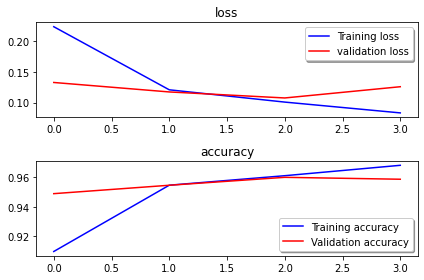

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
ax[0].set_title("loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax[1].set_title("accuracy")
legend = ax[1].legend(loc='best', shadow=True)
fig.tight_layout()

In [ ]:
#140 cv
from tensorflow.keras.layers import Input, Lambda, Bidirectional, Dense, Dropout, LSTM
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, KFold

# K-fold Cross Validation model evaluation
fold_no = 1

#X_train, X_test, y_train, y_test = train_test_split(data, dataset[['label']], test_size=0.3, random_state=4)
def build_model():
  input_layer  = Input(shape=(1,), dtype="string", name="Input_layer")
  embedding_layer = Lambda(ELMoEmbedding, output_shape=(1024, ), name="Elmo_Embedding")(input_layer)

  x = Bidirectional(LSTM(1024, return_sequences= False, recurrent_dropout=0.2, dropout=0.2), name="BiLSTM")(embedding_layer)
  x = Dense(2048, activation="relu")(x)
  x = Dropout(0.1)(x)
  x = Dense(100, activation="relu")(x)
  x = Dropout(0.1)(x)
  x = Dense(1, activation="sigmoid")(x)
  model = Model(inputs=input_layer,outputs=x)
  model.summary()
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model
elmo_LSTM_model = build_model()
kfold = KFold(n_splits=5, random_state=4, shuffle=True)
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
target = dataset[['label']]
with tf.Session() as session:
  session.run(tf.global_variables_initializer()) 
  session.run(tf.tables_initializer())
  fold_no = 1
  for train, test in kfold.split(data, target):
    history = elmo_LSTM_model.fit(data.loc[train], target.loc[train],epochs=1, batch_size=32,verbose = 1)
    scores = elmo_LSTM_model.evaluate(data.loc[test], target.loc[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
Elmo_Embedding (Lambda)      (None, None, 1024)        0         
_________________________________________________________________
BiLSTM (Bidirectional)       (None, 2048)              16785408  
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               204900    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0     

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 40986 samples
40986/40986 [==============================] - 1077s 26ms/sample - loss: 0.0693 - acc: 0.9768
Train on 40986 samples
40986/40986 [==============================] - 1062s 26ms/sample - loss: 0.0364 - acc: 0.9871
Train on 40986 samples
40986/40986 [==============================] - 1058s 26ms/sample - loss: 0.0237 - acc: 0.9918
Train on 40987 samples
40987/40987 [==============================] - 1056s 26ms/sample - loss: 0.0170 - acc: 0.9937
Train on 40987 samples
40987/40987 [==============================] - 1064s 26ms/sample - loss: 0.0137 - acc: 0.9953
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.04319288611526998 - Accuracy: 98.68254065513611%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.023516334944401678 - Accuracy: 99.13145303726196%
--------------------------------------------

### use 120 words

In [ ]:
#120
from tensorflow.keras.layers import Input, Lambda, Bidirectional, Dense, Dropout, LSTM
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, dataset[['label']], test_size=0.3, random_state=4)
def build_model():
  input_layer  = Input(shape=(1,), dtype="string", name="Input_layer")
  embedding_layer = Lambda(ELMoEmbedding, output_shape=(1024, ), name="Elmo_Embedding")(input_layer)

  x = Bidirectional(LSTM(1024, return_sequences= False, recurrent_dropout=0.2, dropout=0.2), name="BiLSTM")(embedding_layer)
  x = Dense(2048, activation="relu")(x)
  x = Dropout(0.1)(x)
  x = Dense(100, activation="relu")(x)
  x = Dropout(0.1)(x)
  x = Dense(1, activation="sigmoid")(x)
  model = Model(inputs=input_layer,outputs=x)
  model.summary()
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model
elmo_LSTM_model = build_model()

with tf.Session() as session:
  session.run(tf.global_variables_initializer()) 
  session.run(tf.tables_initializer())
  history = elmo_LSTM_model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=4, batch_size=128)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
Elmo_Embedding (Lambda)      (None, None, 1024)        0         
_________________________________________________________________
BiLSTM (Bidirectional)       (None, 2048)              16785408  
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               204900    
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0   

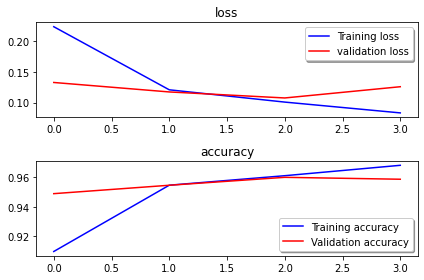

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
ax[0].set_title("loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax[1].set_title("accuracy")
legend = ax[1].legend(loc='best', shadow=True)
fig.tight_layout()

### use 130 words

In [ ]:
#130
from tensorflow.keras.layers import Input, Lambda, Bidirectional, Dense, Dropout, LSTM
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, dataset[['label']], test_size=0.3, random_state=4)
def build_model():
  input_layer  = Input(shape=(1,), dtype="string", name="Input_layer")
  embedding_layer = Lambda(ELMoEmbedding, output_shape=(1024, ), name="Elmo_Embedding")(input_layer)

  x = Bidirectional(LSTM(1024, return_sequences= False, recurrent_dropout=0.2, dropout=0.2), name="BiLSTM")(embedding_layer)
  x = Dense(2048, activation="relu")(x)
  x = Dropout(0.1)(x)
  x = Dense(100, activation="relu")(x)
  x = Dropout(0.1)(x)
  x = Dense(1, activation="sigmoid")(x)
  model = Model(inputs=input_layer,outputs=x)
  model.summary()
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model
elmo_LSTM_model = build_model()

with tf.Session() as session:
  session.run(tf.global_variables_initializer()) 
  session.run(tf.tables_initializer())
  history = elmo_LSTM_model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=4, batch_size=128)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
Elmo_Embedding (Lambda)      (None, None, 1024)        0         
_________________________________________________________________
BiLSTM (Bidirectional)       (None, 2048)              16785408  
_________________________________________________________________
dense_9 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_6 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               204900    
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0   

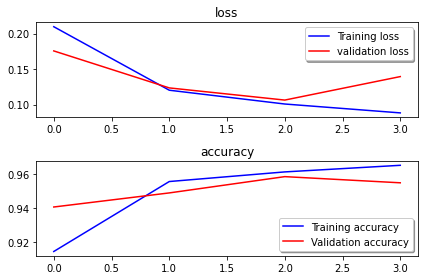

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
ax[0].set_title("loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax[1].set_title("accuracy")
legend = ax[1].legend(loc='best', shadow=True)
fig.tight_layout()

### test

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Bidirectional, Dense, Dropout, LSTM, Flatten, Conv1D, SpatialDropout1D, MaxPooling1D,AveragePooling1D, concatenate, Reshape
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

num_kernels = 128
kernel_sizes= [3,4,5]
pool_sizes = [30,29,28]

#inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
#embed_input = embedding_layer(inputs)

inputs  = Input(shape=(1,), dtype="string", name="Input_layer")
embedding_layer = Lambda(ELMoEmbedding, output_shape=(1024, ), name="Elmo_Embedding")(inputs)

#x = Reshape((32,32))
pool_outputs = []
for i in range(len(kernel_sizes)):
    conv = Conv1D(num_kernels, kernel_size=kernel_sizes[i], padding ='valid', activation='relu')(embedding_layer)
    pool = MaxPooling1D(pool_size=pool_sizes[i], strides=1, padding ='valid')(conv)         
    pool_outputs.append(pool)
merge = concatenate(pool_outputs,axis = 1)

conv = Conv1D(num_kernels, kernel_size=5, activation='relu')(merge)
pool = MaxPooling1D(pool_size=5)(conv)
conv = Conv1D(num_kernels, kernel_size=5, activation='relu')(pool)
pool = MaxPooling1D(pool_size=30)(conv)

#x = Flatten()(pool)
x = Dense(128, activation='relu')(pool)
x = Dropout(0.3)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs,outputs=x)
model.summary() 

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_layer (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
Elmo_Embedding (Lambda)         (None, None, 1024)   0           Input_layer[0][0]                
__________________________________________________________________________________________________
conv1d_65 (Conv1D)              (None, None, 128)    393344      Elmo_Embedding[0][0]             
__________________________________________________________________________________________________
conv1d_66 (Conv1D)              (None, None, 128)    524416      Elmo_Embedding[0][0]             
___________________________________________________________________________________________

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['acc'])

In [ ]:

#recent test
epochs = 2
batch_size = 128
with tf.Session() as sess:
  init = tf.global_variables_initializer()
  sess.run(init)
  X_train, X_test, y_train, y_test = train_test_split(data, dataset[['label']], test_size=0.3, random_state=4)

  history = model.fit(X_train,y_train,epochs = epochs,validation_data=(X_test, y_test), batch_size=batch_size, verbose = 1)
  loss,accuracy = model.evaluate(X_test,y_test)
  print('Accuracy: %f' % (accuracy*100))





Train on 35863 samples, validate on 15370 samples
Epoch 1/2
35863/35863 [==============================] - 528s 15ms/sample - loss: 0.7015 - acc: 0.5137 - val_loss: 0.6933 - val_acc: 0.4873
Epoch 2/2
15370/15370 [==============================] - 200s 13ms/sample - loss: 0.6924 - acc: 0.5191
Accuracy: 51.911640


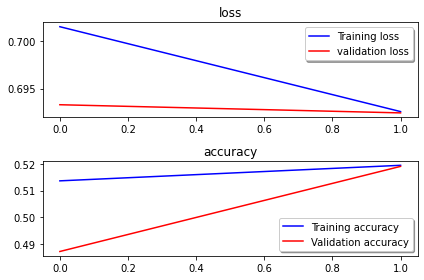

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
ax[0].set_title("loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax[1].set_title("accuracy")
legend = ax[1].legend(loc='best', shadow=True)
fig.tight_layout()

In [ ]:

#recent test
epochs = 2
batch_size = 128
with tf.Session() as sess:
  init = tf.global_variables_initializer()
  sess.run(init)
  X_train, X_test, y_train, y_test = train_test_split(data, dataset[['label']], test_size=0.3, random_state=4)

  history = model.fit(X_train,y_train,epochs = epochs,validation_data=(X_test, y_test), batch_size=batch_size, verbose = 1)
  loss,accuracy = model.evaluate(X_test,y_test)
  print('Accuracy: %f' % (accuracy*100))





Train on 35863 samples, validate on 15370 samples
Epoch 1/2
35863/35863 [==============================] - 531s 15ms/sample - loss: 0.7017 - acc: 0.5164 - val_loss: 0.6926 - val_acc: 0.5191
Epoch 2/2
15370/15370 [==============================] - 201s 13ms/sample - loss: 0.6924 - acc: 0.5191
Accuracy: 51.911640


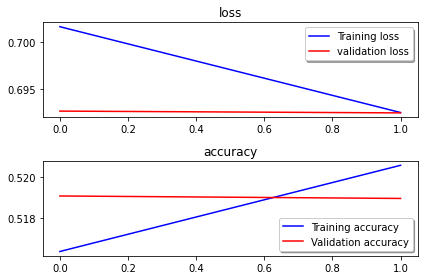

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
ax[0].set_title("loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax[1].set_title("accuracy")
legend = ax[1].legend(loc='best', shadow=True)
fig.tight_layout()

## second dataset

In [ ]:
dataset = pd.read_csv('/content/drive/My Drive/data/data_small_sec.csv', delimiter = ',')
#dataset = dataset[:1000]
data = pd.DataFrame([' '.join(t.split()[0:150]) for t in dataset['text']]) #for saving memory

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Bidirectional, Dense, Dropout, LSTM
from tensorflow.keras.models import Model

X_train, X_test, y_train, y_test = train_test_split(data, dataset[['label']], test_size=0.3, random_state=4)
def build_model():
  input_layer  = Input(shape=(1,), dtype="string", name="Input_layer")
  embedding_layer = Lambda(ELMoEmbedding, output_shape=(1024, ), name="Elmo_Embedding")(input_layer)

  x = Bidirectional(LSTM(1024, return_sequences= False, recurrent_dropout=0.2, dropout=0.2), name="BiLSTM")(embedding_layer)
  x = Dense(2048, activation="relu")(x)
  x = Dropout(0.1)(x)
  x = Dense(100, activation="relu")(x)
  x = Dropout(0.1)(x)
  x = Dense(1, activation="sigmoid")(x)
  model = Model(inputs=input_layer,outputs=x)
  model.summary()
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model
elmo_LSTM_model = build_model()

with tf.Session() as session:
  session.run(tf.global_variables_initializer()) 
  session.run(tf.tables_initializer())
  history = elmo_LSTM_model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=4, batch_size=128)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
Elmo_Embedding (Lambda)      (None, None, 1024)        0         
_________________________________________________________________
BiLSTM (Bidirectional)       (None, 2048)              16785408  
_________________________________________________________________
dense_15 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dropout_10 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               204900    
_________________________________________________________________
dropout_11 (Dropout)         (None, 100)               0   

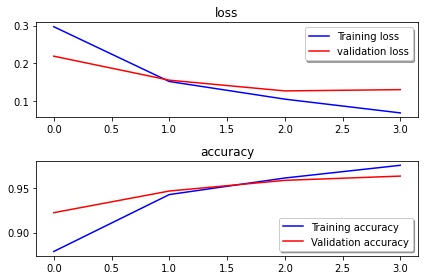

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
ax[0].set_title("loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax[1].set_title("accuracy")
legend = ax[1].legend(loc='best', shadow=True)
fig.tight_layout()

### use 140 words

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Bidirectional, Dense, Dropout, LSTM
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, dataset[['label']], test_size=0.3, random_state=4)
def build_model():
  input_layer  = Input(shape=(1,), dtype="string", name="Input_layer")
  embedding_layer = Lambda(ELMoEmbedding, output_shape=(1024, ), name="Elmo_Embedding")(input_layer)

  x = Bidirectional(LSTM(1024, return_sequences= False, recurrent_dropout=0.2, dropout=0.2), name="BiLSTM")(embedding_layer)
  x = Dense(2048, activation="relu")(x)
  x = Dropout(0.1)(x)
  x = Dense(100, activation="relu")(x)
  x = Dropout(0.1)(x)
  x = Dense(1, activation="sigmoid")(x)
  model = Model(inputs=input_layer,outputs=x)
  model.summary()
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model
elmo_LSTM_model = build_model()

with tf.Session() as session:
  session.run(tf.global_variables_initializer()) 
  session.run(tf.tables_initializer())
  history = elmo_LSTM_model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=4, batch_size=128)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
Elmo_Embedding (Lambda)      (None, None, 1024)        0         
_________________________________________________________________
BiLSTM (Bidirectional)       (None, 2048)              16785408  
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               204900    
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0   

In [ ]:
import matplotlib.pyplot as plt

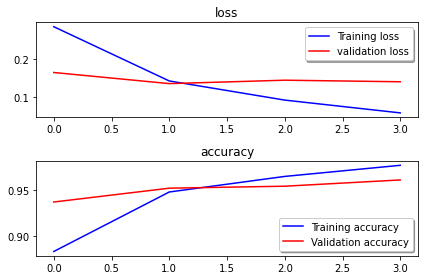

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
ax[0].set_title("loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax[1].set_title("accuracy")
legend = ax[1].legend(loc='best', shadow=True)
fig.tight_layout()

### use 130 words

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Bidirectional, Dense, Dropout, LSTM
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, dataset[['label']], test_size=0.3, random_state=4)
def build_model():
  input_layer  = Input(shape=(1,), dtype="string", name="Input_layer")
  embedding_layer = Lambda(ELMoEmbedding, output_shape=(1024, ), name="Elmo_Embedding")(input_layer)

  x = Bidirectional(LSTM(1024, return_sequences= False, recurrent_dropout=0.2, dropout=0.2), name="BiLSTM")(embedding_layer)
  x = Dense(2048, activation="relu")(x)
  x = Dropout(0.1)(x)
  x = Dense(100, activation="relu")(x)
  x = Dropout(0.1)(x)
  x = Dense(1, activation="sigmoid")(x)
  model = Model(inputs=input_layer,outputs=x)
  model.summary()
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model
elmo_LSTM_model = build_model()

with tf.Session() as session:
  session.run(tf.global_variables_initializer()) 
  session.run(tf.tables_initializer())
  history = elmo_LSTM_model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=4, batch_size=128)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
Elmo_Embedding (Lambda)      (None, None, 1024)        0         
_________________________________________________________________
BiLSTM (Bidirectional)       (None, 2048)              16785408  
_________________________________________________________________
dense_9 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_6 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               204900    
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0   

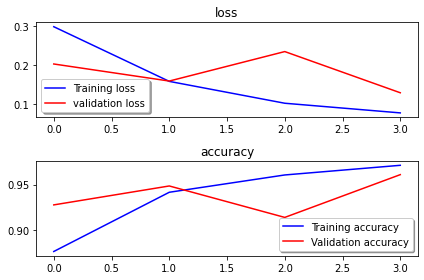

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
ax[0].set_title("loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax[1].set_title("accuracy")
legend = ax[1].legend(loc='best', shadow=True)
fig.tight_layout()

### use 120 words

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Bidirectional, Dense, Dropout, LSTM
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, dataset[['label']], test_size=0.3, random_state=4)
def build_model():
  input_layer  = Input(shape=(1,), dtype="string", name="Input_layer")
  embedding_layer = Lambda(ELMoEmbedding, output_shape=(1024, ), name="Elmo_Embedding")(input_layer)

  x = Bidirectional(LSTM(1024, return_sequences= False, recurrent_dropout=0.2, dropout=0.2), name="BiLSTM")(embedding_layer)
  x = Dense(2048, activation="relu")(x)
  x = Dropout(0.1)(x)
  x = Dense(100, activation="relu")(x)
  x = Dropout(0.1)(x)
  x = Dense(1, activation="sigmoid")(x)
  model = Model(inputs=input_layer,outputs=x)
  model.summary()
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model
elmo_LSTM_model = build_model()

with tf.Session() as session:
  session.run(tf.global_variables_initializer()) 
  session.run(tf.tables_initializer())
  history = elmo_LSTM_model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=4, batch_size=128)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
Elmo_Embedding (Lambda)      (None, None, 1024)        0         
_________________________________________________________________
BiLSTM (Bidirectional)       (None, 2048)              16785408  
_________________________________________________________________
dense_12 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dropout_8 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               204900    
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0   

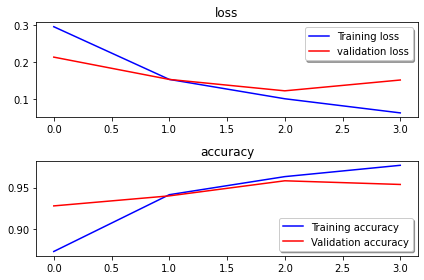

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
ax[0].set_title("loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax[1].set_title("accuracy")
legend = ax[1].legend(loc='best', shadow=True)
fig.tight_layout()